In [9]:
%matplotlib inline

## Solar Angle Calculation

To calculate solar time, first thing to do is to calculate approximate solar time based on local time, time zone and daylight saving. Since the local time on your watch is not actual local solar time, but the solar time of the local time zone meridian.
$$ AST = LST + ET + 4 ( LSM - LON ) $$
where $AST$ is the approximate solar time in minutes, $LST$ is the local standard time in minutes, $LSM$ is the meridian of local standard time in degrees and $LON$ is the local longitude. 4 is the minutes of time required for 1 degree of earth rotation. ET is the equation of time in minutes, obtained by:
$$ ET(n) = 9.87sin(4\pi\frac{n-81}{364})-7.3cos(2\pi\frac{n-81}{364})-1.5sin(2\pi\frac{n-81}{364}) $$
n is the day of year from 1 to 365.
Now to create those to functions in python:

In [10]:
import math
def EquationTime(n):
    if n <1.0 or n > 365.0:
        raise ValueError("n is the day number between 1 and 365")
    else:
        b = 2*math.pi*(n-81.0)/364.0
        return 9.87*math.sin(2*b)-7.3*math.cos(b)-1.5*math.sin(b)

    
def ActualSolarTime(LST, ET, LSM, LON):
    #check if LST is valid
    if LST<0.0 or LST>1440.0:
        raise ValueError("Local Standard Time needs to be in minutes and between 0 and 1440")
    #check if ET is valid
    if ET<-3.563463668700962:
        raise ValueError("Equation Time is invalid")
    #check if LSM is valid
    if LSM > 180 or LSM < -180:
        raise ValueError("Local Standard Time Meridian is within -180 and 180 degrees")
    if LON > 180 or LON < -180:
        raise ValueError("Local Longitude is within -180 and 180 degrees")
    return LST+ET+4*(LSM-LON)

In [11]:
EquationTime(1)

-3.563463668700962

In [12]:
from library.Location import Location
Ottawa = Location("Ottawa", -75.6919, 45.4214)
print(Ottawa.timezone)
print(Ottawa.lsm)

-5.0
-75.0


In [19]:
import numpy as np
day = 100
et = EquationTime(day)
lst = np.arange(24*60)
ast = []
for i in range(0, 24*60):
    ast.append(ActualSolarTime(lst[i],et,Ottawa.lsm,Ottawa.longitude))

print(ast[:10])

[1.3932516400565147, 2.3932516400565147, 3.3932516400565147, 4.3932516400565147, 5.3932516400565147, 6.3932516400565147, 7.3932516400565147, 8.3932516400565156, 9.3932516400565156, 10.393251640056516]


Next is to express the solar time in degrees from the sun's vertical position (noon) to adjust the difference due to time zone:
$$ h = (AST-12.00*60)*0.25 $$

declination angle, the sun's declination due to earth's rotation, is given by:

$$ \delta = sin^{-1}(sin(\frac{23.45}{180}\pi)sin(2\pi\frac{284+n}{365}))$$

altitude angle can be calculated by:
$$ \alpha = sin^{-1}(sin\delta sin\phi + cos\delta cos\phi cos(h))$$
$\phi$ is the latitude

zenith, $\theta$, is then
$$\theta = \frac{1}{2}\pi - \alpha$$

azimuth angle can be calculated by:
$$ A = cos^{-1}(\frac{sin\alpha sin\phi - sin\delta}{cos\alpha cos\phi})\frac{h}{|h|}$$

So to create this sun class in python:

In [20]:
class Sun:
    day = 0
    
    def __init__(self, lat, lon, lsm, day, lst, dst):
        #all angles are now in radiant
        if lat > 180 or lat < -180:
            raise ValueError("Local Longitude is within -180 and 180 degrees")
        else:
            self.latitude = lat/180.0*math.pi
        if lon > 180 or lon < -180:
            raise ValueError("Local Longitude is within -180 and 180 degrees")
        else:
            self.longitude = lon/180.0*math.pi
        if lsm > 180 or lsm < -180:
            raise ValueError("Local Standard Time Meridian is within -180 and 180 degrees")
        else:
            self.localStandardMeridian = lsm/180.0*math.pi
        #daytime saving time range, like [star_date, end_date] as [50,100]
        self.dst = dst
        self.changeDay(day)
        self.update(lst)
       
    def changeDay(self,day):
        if day <1.0 or day > 365.0:
            raise ValueError("n is the day number between 1 and 365")
        else:
            self.day = day
            self.declination = math.asin(math.sin(23.45/180*math.pi)*math.sin(2*math.pi*(284+day)/365))
            #time equation
            b = 2*math.pi*(day-81.0)/364.0
            self.et=9.87*math.sin(2*b)-7.3*math.cos(b)-1.5*math.sin(b)
            #time correction factor
            self.tc = self.et + 4*180/math.pi*(self.localStandardMeridian-self.longitude)
            #sun rise time in local time
            self.sunrise = 12*60 - 4*180/math.pi*math.acos(-math.tan(self.latitude)*math.tan(self.declination)) - self.tc
            #sun set time in local time
            self.sunset = 12*60 + 4*180/math.pi*math.acos(-math.tan(self.latitude)*math.tan(self.declination)) - self.tc
    
    def update(self, lst):
        self.updateSolarTime(lst)
        self.updateAngles(self.ast)
    
    def updateSolarTime(self, lst):
        #check if LST is valid
        if lst<0.0 or lst>1440.0:
            raise ValueError("Local Standard Time needs to be in minutes and between 0 and 1440")
        #check if LSM is valid
        if self.day >= self.dst[0] and self.day <= self.dst[1]:
            self.lst = lst-1
        else:
            self.lst = lst
        self.ast=self.lst + self.tc

    def updateAngles(self,ast):
        self.h = (ast-12.00*60)*0.25 * math.pi/180
        self.altitude = math.asin(math.sin(self.declination)*math.sin(self.latitude) + \
                                  math.cos(self.declination)*math.cos(self.latitude)*math.cos(self.h))
        self.zenith = math.pi/2 - self.altitude
        self.azimuth = math.acos((math.sin(self.altitude)*math.sin(self.latitude)-math.sin(self.declination))/
                                 (math.cos(self.altitude)*math.cos(self.latitude)))*np.sign(self.h)

In [21]:
altitude = []
azimuth = []
solar = Sun(Ottawa.latitude, Ottawa.longitude, Ottawa.lsm, day, lst[0],[72,311])
print(solar.sunrise/60.0)
print(solar.sunset/60.0)

5.475659008785934
18.47789926987885


In [22]:
for i in range(0, len(lst)-1):
    solar.update(lst[i])
    altitude.append(solar.altitude/math.pi*180)
    azimuth.append(solar.azimuth/math.pi*180)

<function matplotlib.pyplot.show>

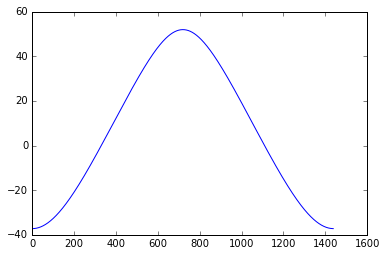

In [23]:
import matplotlib.pyplot as plt
plt.plot(altitude)
plt.show

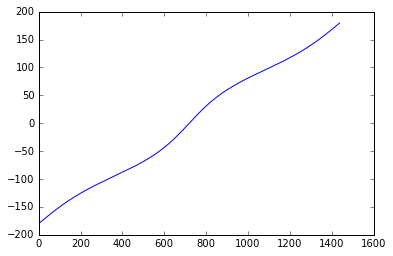

In [24]:
plt.plot(azimuth)
plt.show()

Now the sun angle is calculated, need to calculate incident angle to a tilted and oriented surface, with tile angle $\beta$ and azimuth $A_{s}$.
$$ cos\theta_i = cos\alpha cos(A-A_s)sin\beta + sin\alpha cos\beta$$